# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [ ]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [ ]:
env = UnityEnvironment(file_name="./Tennis.app")

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [ ]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        print("actions type", type(actions), "states type", type(next_states), "rewards type", type(rewards), "dones type", type(dones))
        print(np.asarray(rewards))
        print(np.asarray(dones))
        print("actions shape", actions.shape)
        print("states sahpe", next_states.shape)
        print("rewards shape", np.asarray(rewards).shape)
        print("dones shape", np.asarray(dones).shape)
        
        break
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [1]:
from unityagents import UnityEnvironment
from agent import MADDPGAgent
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import os
import constants as C
import random

In [2]:
def plot(scores, image_folder):
    x = np.arange(len(scores))
    fig, ax = plt.subplots()
    ax.set_ylabel("episode scores")
    ax.set_xlabel("epidsode number")
    plt.ylim((0, 5))
    plt.plot(x, scores)
    if image_folder:
        plt.savefig(os.path.join(image_folder, "plot.png"))
    plt.show()

In [3]:
def run(seed:int=0x10020303):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    env = UnityEnvironment(file_name="./Tennis.app", no_graphics=True)
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    env_info = env.reset(train_mode=True)[brain_name]
    num_agents = len(env_info.agents)
    action_size = brain.vector_action_space_size
    states = env_info.vector_observations
    state_size = states.shape[1]

    device = 'cpu' if not torch.cuda.is_available() else "cuda"

    agent = MADDPGAgent(num_agents, state_size, action_size)

    scores = []
    scores_window = deque(maxlen=C.SCORES_WINDOW_LENGTH)
    print("Starting training")
    steps = 0
    for i in range(1, C.NUM_EPISDOES + 1):
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        obs = env_info.vector_observations
        score = np.zeros(num_agents)

        while True:
            actions = agent.choose_actions(torch.from_numpy(obs).float().to(device), True if i < 100000 else False)
            #actions = np.asarray([np.random.uniform(-1, 1, 2), np.random.uniform(-1, 1, 2)])
            env_info = env.step(actions)[brain_name]
            rewards = np.asarray(env_info.rewards)
            rewards *= 10
            dones = np.array(env_info.local_done).astype(np.uint8)
            next_obs = env_info.vector_observations
            agent.step(obs, actions, rewards , next_obs, dones)
            obs = next_obs
            score += rewards
            steps += 1
            if np.any(dones):
                break
        scores.append(np.max(score))
        scores_window.append(np.max(score))
        if len(scores_window) == C.SCORES_WINDOW_LENGTH and np.mean(scores_window) > C.WINNING_AVG:
            print(f"solved environment in {i} episodes with avg score of {np.mean(scores_window)}")
            agent.save("./")
            env.close()
            return scores, scores_window, True, i
        if i % C.PRINT_EVERY == 0:
            print(f"completed {i} episodes and average score is {np.mean(scores_window)} average steps per episode {steps/i}", end="\n")
    
    env.close()
    return scores, scores_window, False, i

Mono path[0] = '/Users/rkhona/learn/deeprl/tennis/Tennis.app/Contents/Resources/Data/Managed'
Mono config path = '/Users/rkhona/learn/deeprl/tennis/Tennis.app/Contents/MonoBleedingEdge/etc'


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Starting training
completed 10 episodes and average score is 0.0 average steps per episode 14.5
completed 20 episodes and average score is 0.05000000074505806 average steps per episode 15.25
completed 30 episodes and average score is 0.06666666766007741 average steps per episode 16.133333333333333
completed 40 episodes and average score is 0.07250000117346644 average steps per episode 16.075
completed 50 episodes and average score is 0.07600000128149986 average steps per episode 16.02
completed 60 episodes and average score is 0.09333333497246106 average steps per episode 16.283333333333335
completed 70 episodes and average score is 0.09285714450691428 average steps per episode 16.2
completed 80 episodes and average score is 0.08125000144354999 average steps per episode 15.95
completed 90 episodes and average score is 0.07222222350537777 average steps per episode 15.755555555555556
completed 100 episodes and average score is 0.06500000115483999 average steps per episode 15.6
completed 

completed 840 episodes and average score is 0.10800000205636025 average steps per episode 14.948809523809524
completed 850 episodes and average score is 0.09100000169128179 average steps per episode 14.98
completed 860 episodes and average score is 0.11800000220537185 average steps per episode 15.054651162790698
completed 870 episodes and average score is 0.16300000306218862 average steps per episode 15.14367816091954
completed 880 episodes and average score is 0.19900000374764204 average steps per episode 15.243181818181819
completed 890 episodes and average score is 0.21700000409036874 average steps per episode 15.304494382022472
completed 900 episodes and average score is 0.2080000039190054 average steps per episode 15.307777777777778
completed 910 episodes and average score is 0.2360000044107437 average steps per episode 15.348351648351649
completed 920 episodes and average score is 0.2540000047534704 average steps per episode 15.369565217391305
completed 930 episodes and average s

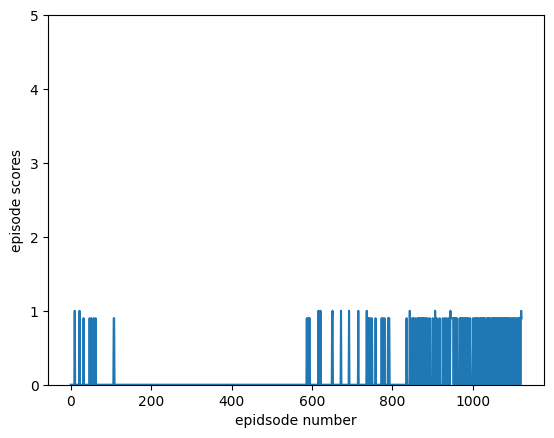

In [4]:
scores, score_window, solved, iterations = run()
if solved:
        plot(scores, "./")